# Classifying nodes on PubMed

Graph sage implements two techniques
- Neighbour sampling
- Aggregation

## Download the dataset

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data', name='Pubmed')
data = dataset[0]

print(f'Dataset: {dataset}')

Dataset: Pubmed()


- It contains 19,717 scientific publications about diabetes from PubMed’s database
- Node features are TF-IDF weighted word vectors with 500 dimensions, which is an efficient way of summarizing documents without transformer
- The task is a multi-class classification with three categories: diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2

In [3]:
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print('Graph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3
Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


There are only 60 training nodes for 1,000 test nodes, which is quite challenging. (6 / 94) split 
- There are only 60 samples to learn how to classify the 1000 test nodes

# Neighbour Sampling

- PyG implements NeighborLoader class to perform this
- Let's keep 10 neighbours(1st hop) of our target node and 10 of their own neighbours(2nd hop)

- We can group 60 target nodes(training nodes) into batches of 16 nodes, which will result in 4 batches

In [4]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(data, num_neighbors=[10, 10], batch_size=16, input_nodes=data.train_mask,)

# Verifying the obtained 4 subgraphs (batches)
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[520, 500], edge_index=[2, 619], y=[520], train_mask=[520], val_mask=[520], test_mask=[520], batch_size=16)
Subgraph 1: Data(x=[300, 500], edge_index=[2, 381], y=[300], train_mask=[300], val_mask=[300], test_mask=[300], batch_size=16)
Subgraph 2: Data(x=[371, 500], edge_index=[2, 454], y=[371], train_mask=[371], val_mask=[371], test_mask=[371], batch_size=16)
Subgraph 3: Data(x=[230, 500], edge_index=[2, 293], y=[230], train_mask=[230], val_mask=[230], test_mask=[230], batch_size=12)


These subgraphs contain more than 60 nodes, which is noraml, since any neighbour can be sampled. Let's plot them!

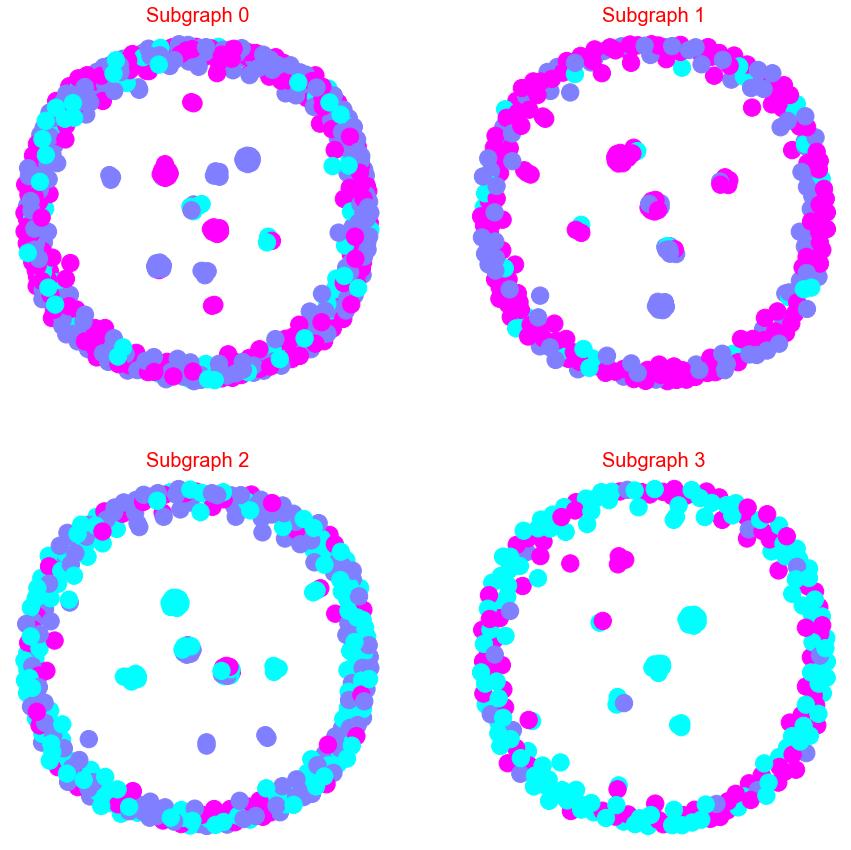

In [23]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import seaborn as sns

fig = plt.figure(figsize=(15, 15))

for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=20, color='red')
    sns.set(style='dark')
    plt.axis('off')
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False, node_color=subdata.y, cmap='cool')
plt.show()

Most of the nodes have a degree of 1 because of the way neighbour sampling works.

In [19]:
for subgraph in train_loader:
    print(subgraph)
    print(subgraph.y.shape)
    break
print(data.y.shape)

Data(x=[515, 500], edge_index=[2, 627], y=[515], train_mask=[515], val_mask=[515], test_mask=[515], batch_size=16)
torch.Size([515])
torch.Size([19717])


- In a transductive setting labels are used for inforamtion diffusion
- In a inductive setting labels are used to tune the GNN's parameters

Transductive learning can only generate embeddings for a fixed graph, which means it can not generalize for unseen nodes or graphs. However, due to neighbour sampling, GraphSAGE is desinged to make predictions at a label level with pruned computation graphs. This is considered as an inductive  framework, since it can be applied to any computation graph with the same feature schema.

In [22]:
# Accuracy of the model
def accuracy(y_pred, y):
    return ((y_pred == y).sum() / len(y)).item()

In [35]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.train()
        
        for epoch in range(epochs+1):
            total_loss, val_loss, acc, val_acc = 0, 0, 0, 0
            
            for  batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss
                
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
                
                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
                
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader) * 100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader) * 100:.2f}%')
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [35]:
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
graphsage.fit(data, 500)

GraphSAGE(
  (sage1): SAGEConv(500, 64)
  (sage2): SAGEConv(64, 3)
)
Epoch   0 | Train Loss: 0.359 | Train Acc:  18.05% | Val Loss: 1.12 | Val Acc: 30.07%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 61.56%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 67.40%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 65.73%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 69.64%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 69.64%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 69.17%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 67.50%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 70.83%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.68 | Val Acc: 66.34%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.66 | V

In [36]:
# Testing the model accuracy
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc * 100:.2f}%')

GraphSAGE test accuracy: 74.00%


# Inductive Learning on Protein-Protein Interactions

- Collection of 24 graphs
- Nodes represents human proteins
- Edges represents physical interactions between proteins in a human cell
- The goal is to perform multi-label classification with 121 labels.

In [24]:
from torch_geometric.datasets import PPI

train_dataset = PPI(root='./data', split='train')
val_dataset = PPI(root='./data', split='val')
test_dataset = PPI(root='./data', split='test')

Extracting data/ppi.zip
Processing...
Done!


In [31]:
# Unify all training examples into one single set
# then apply neighbour sampling

from torch_geometric.data import Batch
from torch_geometric.loader import NeighborLoader

train_data = Batch.from_data_list(train_dataset)
loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)


In [32]:
# Creating batches using DataLoader class
# batch_size = 2 means number of  graphs in each batch
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

In [59]:
# GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!pip install class-resolver

from torch_geometric.nn import GraphSAGE

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

def fit():
    model.train()
    
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    
    return total_loss / len(train_loader.dataset)

from sklearn.metrics import f1_score

@torch.no_grad()
def test(loader):
    model.eval()
    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()
    y, pred = data.y.numpy(), preds.numpy()
    
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [60]:
from tqdm import tqdm

for epoch in tqdm(range(5)):
    loss = fit()
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1 score: {val_f1:.4f}')

 20%|█████████                                    | 1/5 [01:10<04:41, 70.41s/it]

Epoch   0 | Train Loss: 15.811 | Val F1 score: 0.4936


100%|█████████████████████████████████████████████| 5/5 [06:08<00:00, 73.72s/it]


In [61]:
print(f'Test F1 score: {test(test_loader):.4f}')

Test F1 score: 0.7382
